<a href="https://colab.research.google.com/github/youngIcom/Machine_Learning_Project/blob/main/ROI_simulation_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ROI Simulation Modeling

## Apa itu ROI
Roi adalah singkatan dari Return of Investment, yaitu alat yang digunakan untuk mengukur seberapa besar keuntungan bersih yang dihasilkan dibanding dengan biaya yang dikeluarkan. Dalam e-commerce, ROI membantu dalam mengefesiensikan proses, strategi harga dan membantu mengambil keputusan saat terjadi SKU Spike.

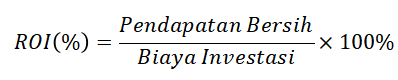

Untuk mendapatkan nilai dari pendapatan bersih dapat digunakan rumus sebagai berikut : Unit Price×Units Sold-Unit Cost×Units Sold-Biaya lain refund, gudang,promosi

biaya investasi dapat diartikan sebagai seluruh biaya yang dikeluarkan.

In [8]:
#Impor library pandas sebagai pd
import pandas as pd

#Gunakan pandas untuk membaca dataset roi.csv dan simpan dalam variabel df
df = pd.read_csv('https://storage.googleapis.com/dqlab-dataset/komdigi/tbl_roi.csv')

#Hitung revenue dengan mengalikan kolom unit_price dengan kolom units_sold dan simpan hasilnya dalam kolom revenue
df['revenue'] = df['unit_price'] * df['units_sold'] #pendapatan yang masuk

#Hitung modal dengan mengalikan kolom unit_cost dengan kolom units_sold dan simpan hasilnya dalam kolom cost
df['cost'] = df['unit_cost']  * df['units_sold'] # modal yang keluar

#Hitung margin percentage berdasarkan rumus yang sudah dijelaskan sebelumnya dan simpan dalam kolom margin_pct
df['margin_pct'] = (df['revenue'] - df['cost']) / df['revenue'] * 100

#Menentukan nilai kerugian akibat refund untuk masing-masing record SKU dan simpan dalam kolom refund_loss
df['refund_loss'] = df['units_refunded'] * df['unit_price']

#Menentukan pendapatan yang sudah dikurangi dengan refund_loss dan simpan dalam kolom adjusted_revenue
df['adjusted_revenue'] = df['revenue'] - df['refund_loss']

#Menandai understock: buat kolom understock_flag (TRUE jika spike_flag == 1 dan units_sold > stock_available)
df['understock_flag'] = (df['spike_flag'] == 1) & (df['units_sold'] > df['stock_available'])

#Menghitung lost_units dan lost_revenue saat understock
df['lost_units'] = df.apply(lambda x: max(0, x['units_sold'] - x['stock_available']) if x['understock_flag'] else 0, axis=1)
df['lost_revenue'] = df['lost_units'] * df['unit_price']

#Menandai overstock: buat kolom overstock_flag (TRUE jika stock_available > units_sold)
df['overstock_flag'] = df['stock_available'] > df['units_sold']

# Menghitung excess_units dan holding_cost (holding_rate = 0.10)
df['excess_units'] = df.apply(lambda x: max(0, x['stock_available'] - x['units_sold']) if x['overstock_flag'] else 0, axis=1)
holding_rate = 0.10
df['holding_cost'] = df['excess_units'] * df['unit_price'] * holding_rate * df['restock_lead_days']

#Tampilkan tabel df terbaru
print(df)

#Buat tabel agregasi per SKU bernama sku_stock berisi total lost_units, lost_revenue, excess_units, dan holding_cost
sku_stock = df.groupby('sku_id')[['lost_units','lost_revenue','excess_units','holding_cost']].sum().reset_index()

#Urutkan sku_stock berdasarkan lost_revenue tertinggi. Simpan hasilnya dalam sku_stock_sorted.
sku_stock_sorted = sku_stock.sort_values(by='lost_revenue', ascending=False)

#Tampilkan 5 baris pertama sku_stock_sorted.
print(sku_stock_sorted.head())


     session_date        sku_id  spike_flag  unit_cost  unit_price  \
0      2025-01-01  DQProduk-001           0   149850.0    239850.0   
1      2025-01-02  DQProduk-001           1   149850.0    239850.0   
2      2025-01-03  DQProduk-001           0   149850.0    239850.0   
3      2025-01-04  DQProduk-001           0   149850.0    239850.0   
4      2025-01-05  DQProduk-001           0   149850.0    239850.0   
...           ...           ...         ...        ...         ...   
3145   2025-03-27  DQProduk-035           1    59850.0    119850.0   
3146   2025-03-28  DQProduk-035           0    59850.0    119850.0   
3147   2025-03-29  DQProduk-035           1    59850.0    119850.0   
3148   2025-03-30  DQProduk-035           0    59850.0    119850.0   
3149   2025-03-31  DQProduk-035           0    59850.0    119850.0   

      units_sold  units_refunded  stock_available  restock_lead_days  \
0             12               0              109                  2   
1             2

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

df['unit_margin'] = df['unit_price'] - df['unit_cost']

df['refund_rate'] = df['units_refunded'] / df['units_sold'].replace(0, 1) * 100

revenue = df['unit_price'] * df['units_sold']
refund_loss = df['units_refunded'] * df['unit_price']
cost = df['unit_cost'] * df['units_sold']
df['roi_value'] = (revenue - cost - refund_loss) / cost.replace(0, 1) * 100

# Membuat target biner roi_class (1 jika roi_value ≥ 20, else 0).
df['roi_class'] = (df['roi_value'] >= 20).astype(int)

# Memilih fitur stock_available, unit_margin, refund_rate, restock_lead_days dan target roi_class
feature_cols = ['stock_available', 'unit_margin', 'refund_rate', 'restock_lead_days']
X = df[feature_cols]
y = df['roi_class']

# Membagi data train–test (80 : 20, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Melatih RandomForestClassifier dengan class_weight='balanced', jumlah estimator = 100, dan random state di 42
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    class_weight='balanced'
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.64      0.64       202
           1       0.83      0.83      0.83       428

    accuracy                           0.77       630
   macro avg       0.74      0.74      0.74       630
weighted avg       0.77      0.77      0.77       630



Kesimpulan :
Secara singkat, laporan ini memberitahu kita bahwa modelmu cukup baik (akurasi 77%), dan ia jauh lebih pintar dalam memprediksi produk dengan ROI tinggi (Kelas 1) daripada produk dengan ROI rendah (Kelas 0).